## Data Preprocessing

In this part, we cleaned the dataset, remove uncorrelated variables, filter out the data we want to focus on and roughly analyzed it.

In [15]:
#Importing packages we want
import pandas as pd
import numpy as np
import collections
import re
import heapq
import matplotlib.pyplot as plt
from collections import defaultdict
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline


In [2]:
#Reading twitter data which are labeled as Russian Trolls
df = pd.read_csv('twitter.csv')

C:\Users\cheny\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (1,11,16,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
## All those helper functions we build for cleaning the processing our dataset:

#Functions which can help us extract more time information 
def get_mdy(string):
    return string.split()[0]
def get_hm(string):
    return string.split()[1]
def get_month(string):
    return int(string.split('/')[0])
def get_date(string):
    return int(string.split('/')[1])
def get_hour(string):
    return int(string.split(':')[0])

#Functions which can help us extract all hash tags of one tweet
def get_hash_tags(contents):
    word_list = []
    for sentence in contents:
        if isinstance(sentence, str):
            word_list += re.findall('#(\w+)', sentence)
    return word_list

#Functions to count each hashtag
def count_hashtags(hash_tags):
    tag_to_num = collections.defaultdict(int)
    for hashtag in hash_tags:
        tag_to_num[hashtag] += 1 
    return tag_to_num

def get_hash_tag(content):
    if isinstance(content, str):
        word_list = re.findall('#(\w+)' , content)
        return word_list
    return []

def count_num(hash_list):
    return len(hash_list)

#Functions which can help us extract information after symbol '@' can count the number of them
pattern2 = '@(\w+)'
def get_at_tags(pattern, contents):
    word_list = []
    for sentence in contents:
        if isinstance(sentence, str):
            word_list += re.findall(pattern, sentence)
    return word_list
def count_attags(at_tags):
    tag_to_num = collections.defaultdict(int)
    for hashtag in at_tags:
        tag_to_num[hashtag] += 1 
    return tag_to_num

#Functions which can help us get the 5 most frequently appearing tags
def find_top5_ht(tag_list):
    tag_to_num = defaultdict(int)
    for tag in tag_list:
        tag_to_num[tag] += 1
    heap = []
    for tag in tag_to_num:
        heapq.heappush(heap, (tag_to_num[tag], tag))
    while len(heap) > 5:
        heapq.heappop(heap)
    return heap

def get_tags(tag_list):
    tags = []
    for num, tag in tag_list:
        tags.append(tag)
    tags = list(reversed(tags))
    return tags

#Functions helping us transforming tweet content to suitable format
def no_hashtag(content):
    number = [0]*len(content)
    for i in range(len(content)):
        pattern = re.compile(r'#\w+')
        number[i] = len(pattern.findall(content[i]))
    return number

def no_at(content):
    number = [0]*len(content)
    for i in range(len(content)):
        pattern = re.compile(r'@\w+')
        number[i] = len(pattern.findall(content[i]))
    return number

#Functions for wordcloud analysis
def remove_url(content):
    for i in range(len(content)):
        text = re.sub(r'https?:\/\/.*[\r\n]*', '', content[i], flags=re.MULTILINE)
        content[i] = text
    return content

def remove_hashtags(content):
    for i in range(len(content)):
        text = re.sub(r'#\w+', '', content[i], flags=re.MULTILINE)
        content[i] = text
    return content

def remove_at(content):
    for i in range(len(content)):
        text = re.sub(r'@\w+', '', content[i], flags=re.MULTILINE)
        content[i] = text
    return content

def remove_stop_words(content):
    from wordcloud import STOPWORDS
    for i in range(len(content)):
        pattern = re.compile(r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*')
        content[i] = pattern.sub('', content[i].lower())
    return content

#Other functions
def remove_punctuations(content):
    for i in range(len(content)):
        pattern = re.compile(r'[^\w\s]')
        content[i] = pattern.sub('',content[i])
    return content

def sentiment_score(s:str):
    score = TextBlob(s).sentiment[0]
    return score

def contain_topic(topic:str,s:str):
    topic_pattern = re.compile(topic)
    matching = topic_pattern.search(s.lower())
    return (matching != None)

In [4]:
#Checking structure of the dataset
df.head()

,Unnamed: 0,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,...,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
0,0,906000000000000000,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,...,Right,0,RightTroll,0,905874659358453760,914580356430536707,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN
1,1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,...,Right,0,RightTroll,0,905874659358453760,914621840496189440,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN
2,2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,...,Right,1,RightTroll,0,905874659358453760,914623490375979008,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/913231923715...,NaN,NaN
3,3,906000000000000000,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,...,Right,0,RightTroll,0,905874659358453760,914639143690555392,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914639143690...,NaN,NaN
4,4,906000000000000000,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,...,Right,1,RightTroll,0,905874659358453760,914312219952861184,http://twitter.com/905874659358453760/statuses...,https://twitter.com/realDonaldTrump/status/914...,NaN,NaN


From the table above we can find that there might be some columns that are not closely related with our final result, for example, columns like external_author_id, artical_url and tweet_id are used to distinguish one specific tweet. Under this circumstance, we can just drop them to get better prediction.

In [5]:
# Dropping some columns which may not be significant for our further analysis
df.drop(columns = ['Unnamed: 0', 'external_author_id', 'article_url', 'harvested_date'], axis = 1, inplace = True)

After dropping some of the unrelated variables, the next step we decided to do is working with the null value, which will influence our further analysis.

In [6]:
# Checking for null valus
df.isnull().sum()

author                    0
content                   1
region                 8818
language                  0
publish_date              0
following                 0
followers                 0
updates                   0
post_type           1648625
account_type              0
retweet                   0
account_category          0
new_june_2018             0
alt_external_id           0
tweet_id                  0
tco1_step1           845971
tco2_step1          2235090
tco3_step1          2931207
dtype: int64

In [7]:
# Since there are too many null values in ['tco2_step1', 'tco3_step1'] columns, we can drop them 
df.drop(columns = ['tco2_step1', 'tco3_step1'], axis = 1, inplace = True)

In [8]:
# Getting the percentage of how many tweets come from the United States
print(df.region.unique())
print(len(df[df['region'] == 'United States']) / len(df))

['Unknown' nan 'United States' 'Italy' 'United Arab Emirates' 'Japan'
 'Israel' 'Azerbaijan' 'Egypt' 'United Kingdom' 'Russian Federation'
 'Turkey' 'Iraq' 'Germany' 'France' 'Ukraine' 'Serbia' 'Hong Kong'
 'Austria' 'Belarus' 'Malaysia' 'Spain' 'Samoa' 'India' 'Afghanistan'
 'Saudi Arabia' 'Iran, Islamic Republic of' 'Mexico' 'Canada' 'Greece'
 'Czech Republic' 'Finland' 'Latvia' 'Estonia' 'Sweden' 'Denmark'
 'Switzerland']
0.6946928712069451


In [9]:
# Getting the percentage of how many tweets are English
print(df.language.unique())
print(len(df[df['language'] == 'English']) / len(df))

['English' 'Russian' 'Serbian' 'Ukrainian' 'Tagalog (Filipino)' 'Albanian'
 'Italian' 'Romanian' 'Spanish' 'Catalan' 'German' 'Estonian' 'French'
 'Norwegian' 'Vietnamese' 'Dutch' 'Arabic' 'Uzbek' 'Bulgarian'
 'Macedonian' 'Farsi (Persian)' 'Turkish' 'LANGUAGE UNDEFINED' 'Czech'
 'Somali' 'Lithuanian' 'Croatian' 'Slovak' 'Icelandic' 'Slovenian'
 'Japanese' 'Indonesian' 'Pushto' 'Hungarian' 'Finnish' 'Latvian'
 'Portuguese' 'Danish' 'Swedish' 'Malay' 'Polish' 'Korean' 'Hebrew' 'Urdu'
 'Kurdish' 'Hindi' 'Greek' 'Simplified Chinese' 'Thai' 'Bengali'
 'Traditional Chinese' 'Gujarati' 'Kannada' 'Tamil' 'Telugu' 'Malayalam']
0.7185058619438485


Based on these two numbers - 69.46% and 71.85%, we know that most of the tweets are written in English and sent from the United States, so we can only using data that matches these two criteria.

In [10]:
df[df['account_category'] == 'NonEnglish'].language.value_counts()

Russian               610797
German                 86205
Ukrainian              38642
English                26562
Italian                13754
Serbian                 9473
Bulgarian               9156
Uzbek                   8828
Arabic                  5305
Macedonian              5174
French                  2148
LANGUAGE UNDEFINED      1772
Swedish                  574
Spanish                  462
Norwegian                448
Turkish                  207
Dutch                    197
Portuguese               147
Finnish                  117
Japanese                 111
Romanian                  95
Farsi (Persian)           72
Catalan                   67
Pushto                    52
Icelandic                 36
Kurdish                   36
Croatian                  35
Hungarian                 32
Polish                    32
Vietnamese                31
Estonian                  29
Hebrew                    29
Czech                     24
Albanian                  22
Lithuanian    

In [11]:
df[df['account_category'] != 'NonEnglish'].language.value_counts()

English                2090305
LANGUAGE UNDEFINED        6548
Italian                   4309
Spanish                   2549
French                    2414
Arabic                    2283
Norwegian                 1789
Farsi (Persian)           1612
Romanian                  1534
Dutch                      968
Vietnamese                 951
German                     778
Estonian                   741
Japanese                   653
Albanian                   550
Catalan                    522
Croatian                   509
Uzbek                      506
Finnish                    462
Icelandic                  462
Swedish                    440
Pushto                     435
Lithuanian                 395
Polish                     354
Portuguese                 316
Somali                     272
Slovak                     241
Turkish                    238
Tagalog (Filipino)         236
Malay                      228
Latvian                    200
Kurdish                    199
Greek   

In [12]:
language_fre = df.groupby(['author','account_category'],as_index=False).agg({'language': lambda x: (x=='English').sum()/(x!='').sum()})

In [13]:
language_fre[language_fre['account_category'] == 'NonEnglish'][['language']]

,language
1,0.000000
4,0.020321
6,0.000000
7,0.025738
10,0.001613
...,...
2836,0.182803
2838,0.000000
2839,0.001953
2841,0.000000


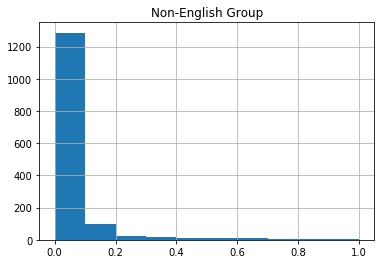

In [22]:
language_fre[language_fre['account_category'] == 'NonEnglish'].hist()
plt.title('Non-English Group')
plt.show()

In [17]:
language_fre[language_fre['account_category'] != 'NonEnglish']

,author,account_category,language
0,10_GOP,RightTroll,1.000000
2,1D_NICOLE_,Fearmonger,0.931818
3,1ERIK_LEE,RightTroll,1.000000
5,2NDHALFONION,RightTroll,1.000000
8,4EVER_SUSAN,RightTroll,0.984127
...,...,...,...
2831,_NICKLUNA_,RightTroll,0.982332
2834,_RONBEN,RightTroll,0.985714
2835,_RUBY_WILLS_,RightTroll,0.997059
2837,_SHERYLGILBERT,RightTroll,0.971014


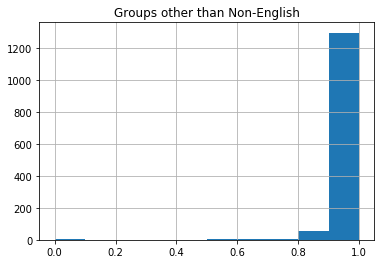

In [21]:
language_fre[language_fre['account_category'] != 'NonEnglish'].hist()
plt.title('Groups other than Non-English')
plt.show()

Different languages has been used by both the Non-English group and the other groups. According to the working papaer, the Non-english group were filtered out based on how prodominant a foreign language has been used. According to these two histograms above, account that is not NonEnglish, majority of them used English a lot. On the contrary, the Non-English Accounts used language other than English a lot. To maintain consistency with the working paper, we chose to filtered the Non-English group directly. Also, several accounts were identflied mannualy as not related to political agenda building. We removed these twitter handles as well.

In [19]:
df = df[(df['account_category'] !='NonEnglish') \
                  &(df['account_category'] !='Commercial') \
                  &(df['account_category'] !='Unknown')]

In [20]:
df.shape

(1989961, 16)

In [19]:
'''#Filter out the data we want to focus on
df = df[df['language'] == 'English']
df = df[df['region'] == 'United States']the 
'''

"#Filter out the data we want to focus on\ndf = df[df['language'] == 'English']\ndf = df[df['region'] == 'United States']the \n"

Based on our assumption, those Troll acounts will be more actively when politics events happened, to check for the correctness of this assumption, we hope we can extract more time information, helping us match different pattern with specific events. To do so, we build more features showing more time information about each tweet.


In [20]:
#Split data
df['pb_mdy_info'] = df.publish_date.apply(get_mdy)
df['pb_hm_info'] = df.publish_date.apply(get_hm)

In [21]:
#Tansfer original date data into standard forms we want
df['pb_month'] = df.pb_mdy_info.apply(get_month)
df['pb_date'] = df.pb_mdy_info.apply(get_date)
df['pb_hour'] = df.pb_hm_info.apply(get_hour)

In [22]:
#Dataset structure after basic cleaning
df.head()

,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,...,account_category,new_june_2018,alt_external_id,tweet_id,tco1_step1,pb_mdy_info,pb_hm_info,pb_month,pb_date,pb_hour
0,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,1052,9636,253,NaN,Right,...,RightTroll,0,905874659358453760,914580356430536707,https://twitter.com/10_gop/status/914580356430...,10/1/2017,19:58,10,1,19
1,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,1054,9637,254,NaN,Right,...,RightTroll,0,905874659358453760,914621840496189440,https://twitter.com/damienwoody/status/9145685...,10/1/2017,22:43,10,1,22
2,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,1054,9637,255,RETWEET,Right,...,RightTroll,0,905874659358453760,914623490375979008,https://twitter.com/10_gop/status/913231923715...,10/1/2017,22:50,10,1,22
3,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,1062,9642,256,NaN,Right,...,RightTroll,0,905874659358453760,914639143690555392,https://twitter.com/10_gop/status/914639143690...,10/1/2017,23:52,10,1,23
4,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,1050,9645,246,RETWEET,Right,...,RightTroll,0,905874659358453760,914312219952861184,https://twitter.com/realDonaldTrump/status/914...,10/1/2017,2:13,10,1,2


Hash tag is an important part we want to focus on because it represents the topic of each tweets, in order to split hash tags from tweets, we defined some helper functions using regular expresssion. Then, after geting hash tags, we grouped them and count to see what topics are people most care about.

In [23]:
# Getting hashtags from tweets(Using regex)

In [24]:
sum(df['content'].isna())

1

In [25]:
np.where(df['content'].isna())

(array([972696], dtype=int64),)

In [26]:
df['content'].iloc[972696] = ' '

C:\Users\cheny\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [27]:
contents = df['content'].tolist()

In [28]:
#Applying fuction to dataset and get hashtags
hash_tags = get_hash_tags(contents)

In [29]:
# Checking for some of our results
hash_tags[:20]

['BoycottNFL',
 'StandForOurAnthem',
 'HipHopAwards',
 'Iran',
 'MAGA',
 'WomenBoycottTwitter',
 'FakeNews',
 'LasVegas',
 'LasVegas',
 'LasVegasShooting',
 'LasVegasStrong',
 'LasVegasShooting',
 'VegasStrong',
 'VegasStrong',
 'BoycottNFL',
 'SanJuan',
 'TakeAKnee',
 'FakeNews',
 'PRStrong',
 'NFLBoycott']

In [30]:
# Counting the number of different hashtags
tag_to_num = count_hashtags(hash_tags)
tag_to_num

defaultdict(int,
            {'BoycottNFL': 112,
             'StandForOurAnthem': 12,
             'HipHopAwards': 18,
             'Iran': 559,
             'MAGA': 14787,
             'WomenBoycottTwitter': 1,
             'FakeNews': 1265,
             'LasVegas': 35,
             'LasVegasShooting': 11,
             'LasVegasStrong': 1,
             'VegasStrong': 10,
             'SanJuan': 2,
             'TakeAKnee': 84,
             'PRStrong': 2,
             'NFLBoycott': 37,
             'IrmaHurricane2017': 3,
             'HurrcaneIrma': 6,
             'FightCensorship': 1,
             'FreeSpeech': 96,
             'LiberalAttack': 1,
             'HurricaneIrma': 10,
             'Irma': 9,
             'TampaReady': 1,
             'FLORIDAHURRICANE': 1,
             'FreeTennessee': 28,
             '60Minutes': 53,
             'IRMA': 1,
             'AfterIrma': 2,
             'TropicalStormIrma': 2,
             'NeverForget': 375,
             'NeverForget911'

In [31]:
#How many unique hashtags we got
len(tag_to_num)

91591

After extracting information related to hashtag, we started to think which variable might also be significant for our prediction, and the answer is information hided by the '@' symbol. So we use different tools trying to get those data.

In [32]:
at_list = get_at_tags(pattern2, contents)

In [33]:
at_to_num = count_attags(at_list)
at_to_num

defaultdict(int,
            {'nedryun': 6,
             'SenatorMenendez': 19,
             'CarmenYulinCruz': 3,
             'CNN': 2971,
             'thehill': 409,
             'MichelleObama': 67,
             'FLOTUS': 389,
             'Breaking911': 82,
             'realDonaldTrump': 12851,
             'POTUS': 4906,
             'Joy_Villa': 52,
             'Cernovich': 471,
             'KFILE': 10,
             'AP_Politics': 27,
             'PrisonPlanet': 458,
             'GrrrGraphics': 51,
             'YouTube': 3734,
             'TeamYouTube': 21,
             'SteveScalise': 23,
             '10_gop': 9,
             'SebGorka': 165,
             'LauraLoomer': 13,
             'HillaryClinton': 4353,
             'JackPosobiec': 182,
             'benshapiro': 195,
             'FoxNews': 2877,
             'NaeguNugu': 1,
             'TEN_GOP': 288,
             'jojoh888': 39,
             '5sahandful': 1,
             'SLMPD': 17,
             'exposes_ra

In [34]:
#Seeing the remaining null values in dataset
df.isnull().sum()

author                    0
content                   0
region                 1138
language                  0
publish_date              0
following                 0
followers                 0
updates                   0
post_type           1156173
account_type              0
retweet                   0
account_category          0
new_june_2018             0
alt_external_id           0
tweet_id                  0
tco1_step1           756708
pb_mdy_info               0
pb_hm_info                0
pb_month                  0
pb_date                   0
pb_hour                   0
dtype: int64

In [35]:
#Post type of tweets
df.post_type.unique()

array([nan, 'RETWEET', 'QUOTE_TWEET'], dtype=object)

## Descriptive Analysis

In this part we dived deeper in our dataset and did some basic descriptive analysis, from the plots we can clearly see Tweets trends and accounts with more followers. Also, we grouped tweets by day and find top 5 hashtags of each day to see whether there's any pattern. Used aggregate function to generate informations of each accounts including total posts, average following, average followers, usually posting time, what kinds of hashtags they have used and their account type.

In [36]:
# Some basic descriptive analysis

C:\Users\cheny\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


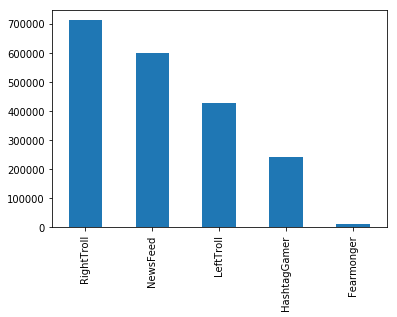

In [37]:
df['account_category'].value_counts().plot('bar')

As we can see here, NonEngilsh group together posted the most tweets during the presidential cycle. A

C:\Users\cheny\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


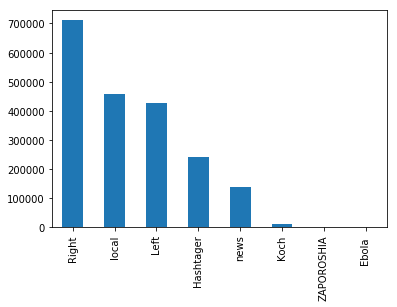

In [38]:
df['account_type'].value_counts().plot('bar')

In [39]:
#See the top tag of these tweets
sorted(tag_to_num.items(), key = lambda item: item[1], reverse=True)
#We can find that there're many tags related to politics

[('news', 127119),
 ('sports', 48568),
 ('politics', 39702),
 ('world', 27557),
 ('local', 25815),
 ('TopNews', 15146),
 ('MAGA', 14787),
 ('BlackLivesMatter', 11991),
 ('health', 11466),
 ('tcot', 11458),
 ('business', 10819),
 ('PJNET', 10449),
 ('tech', 8223),
 ('entertainment', 7574),
 ('top', 7417),
 ('Cleveland', 6706),
 ('TopVideo', 6546),
 ('crime', 6501),
 ('environment', 5783),
 ('NowPlaying', 5350),
 ('ISIS', 5321),
 ('Trump', 4993),
 ('mar', 4865),
 ('Miami', 4575),
 ('breaking', 4515),
 ('topl', 4399),
 ('FAKENEWS', 4353),
 ('IslamKills', 4213),
 ('SanJose', 4173),
 ('2A', 4136),
 ('WakeUpAmerica', 4089),
 ('life', 3949),
 ('GOPDebate', 3824),
 ('KochFarms', 3790),
 ('DemnDebate', 3578),
 ('TCOT', 3476),
 ('ccot', 3428),
 ('ToDoListBeforeChristmas', 3422),
 ('Chicago', 3296),
 ('ThingsYouCantIgnore', 2966),
 ('amb', 2914),
 ('DemDebate', 2842),
 ('TrumpTrain', 2834),
 ('US', 2688),
 ('Texas', 2619),
 ('Syria', 2610),
 ('may', 2583),
 ('p2', 2580),
 ('IGetDepressedWhen', 25

In [40]:
#How many unique accounts
df.author.nunique()

1153

In [41]:
#Maybe in later analysis we can filter those accounts without any followers bacuse they may not have much impact on citizens
df.groupby('author')['followers'].max().sort_values(ascending = False)

author
TEN_GOP           145244
JENN_ABRAMS        71022
PAMELA_MOORE13     70734
TODAYNYCITY        62088
ELEVEN_GOP         59100
                   ...  
AMYYSSTS               0
AMYYTHOSSMA            0
NATTATRT               0
TAYYSSTRUT             0
DNT_SHOOT              0
Name: followers, Length: 1153, dtype: int64

In [42]:
top_following = list(df.groupby('author')['followers'].max().sort_values(ascending = False)[:100].index)

C:\Users\cheny\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


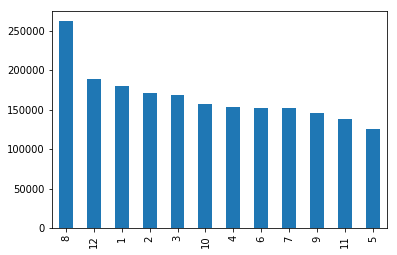

In [43]:
#Tweets trend in months
df.pb_month.value_counts().plot('bar')

C:\Users\cheny\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  This is separate from the ipykernel package so we can avoid doing imports until


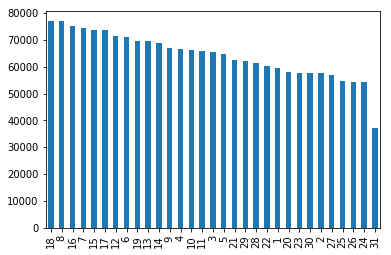

In [44]:
#Tweets trend in days
# These accounts tend to tweets during the middle of months
df.pb_date.value_counts().plot('bar')

In [45]:
df.post_type.value_counts()

RETWEET        803030
QUOTE_TWEET     30758
Name: post_type, dtype: int64

In [46]:
#About half of the handles follow more than 500 accounts
df.groupby('author')['following'].max().sort_values(ascending = False).loc[lambda x: x > 500].count()

557

In [47]:
df['hashtags'] = df.content.apply(get_hash_tag)

In [48]:
df['hashtag_num'] = df.hashtags.apply(count_num)

In [50]:
#Use aggregate function to count how many hashtags in each tweet
time_df = df.groupby('pb_mdy_info').agg({'hashtags': 'sum', 'hashtag_num': 'count'})

In [51]:
time_df['top5_tags'] = time_df.hashtags.apply(find_top5_ht)

In [52]:
time_df['top_5_tag'] = time_df.top5_tags.apply(get_tags)

In [53]:
time_df.head()

,hashtags,hashtag_num,top5_tags,top_5_tag
pb_mdy_info,,,,
1/1/2013,[],1,[],[]
1/1/2015,"[art, Miami, art, news, art, Miami, politics, ...",5,"[(1, politics), (2, Miami), (2, news), (4, art)]","[art, news, Miami, politics]"
1/1/2016,"[thankSAll, sports, sports, sports, sports, sp...",955,"[(32, local), (38, world), (54, politics), (28...","[sports, news, politics, world, local]"
1/1/2017,"[recipe, Can_I_Live, ad, recipe, NowPlaying, p...",2444,"[(16, HappyNewYear), (19, tcot), (24, 2A), (21...","[MAGA, NowPlaying, 2A, tcot, HappyNewYear]"
1/10/2015,"[ff, ff, MarkTwain, TheAdventuresofTomSawyer, ...",483,"[(10, Miami), (10, politics), (28, news), (26,...","[local, sports, news, politics, Miami]"


In [54]:
df.head()

,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,...,alt_external_id,tweet_id,tco1_step1,pb_mdy_info,pb_hm_info,pb_month,pb_date,pb_hour,hashtags,hashtag_num
0,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,1052,9636,253,NaN,Right,...,905874659358453760,914580356430536707,https://twitter.com/10_gop/status/914580356430...,10/1/2017,19:58,10,1,19,[],0
1,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,1054,9637,254,NaN,Right,...,905874659358453760,914621840496189440,https://twitter.com/damienwoody/status/9145685...,10/1/2017,22:43,10,1,22,[],0
2,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,1054,9637,255,RETWEET,Right,...,905874659358453760,914623490375979008,https://twitter.com/10_gop/status/913231923715...,10/1/2017,22:50,10,1,22,[BoycottNFL],1
3,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,1062,9642,256,NaN,Right,...,905874659358453760,914639143690555392,https://twitter.com/10_gop/status/914639143690...,10/1/2017,23:52,10,1,23,[],0
4,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,1050,9645,246,RETWEET,Right,...,905874659358453760,914312219952861184,https://twitter.com/realDonaldTrump/status/914...,10/1/2017,2:13,10,1,2,[StandForOurAnthem],1


In [55]:
#Analysis below is user information part

In [56]:
df['post'] = 1
grouped = df.groupby('author')

In [57]:
df.head()

,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,...,tweet_id,tco1_step1,pb_mdy_info,pb_hm_info,pb_month,pb_date,pb_hour,hashtags,hashtag_num,post
0,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,1052,9636,253,NaN,Right,...,914580356430536707,https://twitter.com/10_gop/status/914580356430...,10/1/2017,19:58,10,1,19,[],0,1
1,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,1054,9637,254,NaN,Right,...,914621840496189440,https://twitter.com/damienwoody/status/9145685...,10/1/2017,22:43,10,1,22,[],0,1
2,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,1054,9637,255,RETWEET,Right,...,914623490375979008,https://twitter.com/10_gop/status/913231923715...,10/1/2017,22:50,10,1,22,[BoycottNFL],1,1
3,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,1062,9642,256,NaN,Right,...,914639143690555392,https://twitter.com/10_gop/status/914639143690...,10/1/2017,23:52,10,1,23,[],0,1
4,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,1050,9645,246,RETWEET,Right,...,914312219952861184,https://twitter.com/realDonaldTrump/status/914...,10/1/2017,2:13,10,1,2,[StandForOurAnthem],1,1


In [58]:
#Use aggregate function to generate information of each accounts
user_info = grouped.agg({'post': 'sum', 'following': 'mean', 'pb_hour': 'mean',  'followers': 'mean', 'hashtag_num': 'mean', 'hashtags':'sum', 'account_type': 'max'})
user_info

,post,following,pb_hour,followers,hashtag_num,hashtags,account_type
author,,,,,,,
10_GOP,372,985.018817,12.588710,7044.306452,0.298387,"[BoycottNFL, StandForOurAnthem, HipHopAwards, ...",Right
1D_NICOLE_,44,58.500000,12.840909,51.477273,0.295455,"[FoodPoisoning, Walmart, KochFarms, turkey, Ko...",Koch
1ERIK_LEE,2,239.000000,9.000000,74.000000,2.000000,"[petition, NoGunsForCriminals, black, NoGunsFo...",Right
2NDHALFONION,3,22.000000,22.000000,1.000000,0.000000,[],Right
4EVER_SUSAN,63,75.650794,13.857143,57.777778,1.603175,"[Raiders, Carr, RaiderNation, Raiders, MikeAnd...",Right
...,...,...,...,...,...,...,...
_NICKLUNA_,4245,1326.393404,12.600236,1206.645701,0.720141,"[RINOs, Republicans, UniteRight, PJNet, VoteTr...",Right
_RONBEN,70,114.328571,9.000000,87.842857,1.042857,"[GOPStop, GOPDebate, GOPDebate, GOPStop, GOPSt...",Right
_RUBY_WILLS_,340,479.508824,6.102941,159.485294,1.794118,"[GOP, StopTheGOP, election, stoptheGOP, VoteBl...",Right


## Wordcloud Analysis

In [59]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate(' '.join(hash_tags))

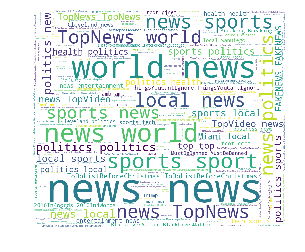

In [60]:
# wordcloud from hashtages
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
wordcloud.to_file('hash_tag_wordcloud.png')

In [61]:
content = list(df['content'])

In [62]:
content = remove_url(content)
content = remove_hashtags(content)
content = remove_at(content)
content_str = ' '.join(content)

In [63]:
from PIL import Image
stopwords = set(STOPWORDS)
more_words = ['now', 'said', 'say', 'amp', 'one']
for i in more_words:
    stopwords.add(i)

In [64]:
import numpy as np
from wordcloud import ImageColorGenerator

# read the mask / color image taken from
dt_coloring = np.array(Image.open("dt0.jpg"))

wc = WordCloud(background_color="white", max_words=2000, mask=dt_coloring,
               stopwords=stopwords, max_font_size=200, random_state=42).generate(content_str)

# create coloring from image
image_colors = ImageColorGenerator(dt_coloring)

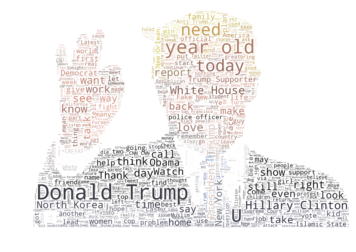

<Figure size 432x288 with 0 Axes>

In [65]:
# wordcloud from cleaned contents
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
wc.to_file('content_colored_no_noise.png')

## code to output a daily wc csv file you don't have to run this as we have provided the csv file with you

```python
contents_for_daily_wc = remove_url(contents)
contents_for_daily_wc = remove_stop_words(contents_for_daily_wc)
contents_for_daily_wc = remove_punctuations(contents_for_daily_wc)```

```python
df_contents_daily_wc = df[['pb_mdy_info']]
df_contents_daily_wc['content'] = contents_for_daily_wc
df_contents_daily_wc.content = df_contents_daily_wc.content.map(str.rstrip)#trim
df_contents_daily_wc.content = df_contents_daily_wc.content.map(str.split)#split
```

```python
df_contents_daily_wc.head()
```

```python
word_time_series=[]

for i in range(len(df_contents_daily_wc)):
    for word in df_contents_daily_wc.iloc[i,1]:
        word_date = []
        word_date.extend([word,df_contents_daily_wc.iloc[i,0]])
        word_time_series.append(word_date)
```

```python
word_time_df = pd.DataFrame(word_time_series,columns = ['word','date'])
word_time_df.to_csv('word_time.csv',index=False)
```

## Building Machine Learning Models

After cleaned our dataset, did some feature engineering and made some descriptive analysis. Our team started to think what kind of process we should follow if we want to use our model for the upcoming election. Is putting each data to one complicated NLP model a good choice? We don't think so, since to do so, we should first transform all context to vectors and then call our model. This solution will cost a lot of money and time.


To better deal with this problem, we separate our process of checking whether a tweet might be a problematic one to three steps: first, we build a model, which can help us quickly clarify whether this tweet includes political information. If it includes, we will send this data to our second model, which will check if the author of that tweet is a suspicious account or notFinally, we will predict what kind of the account should be, a right troll? Left troll? Or others


To build this first model, we use one new dataset, which includes tweet data and its corresponded label. Each label can be either 'POLIT' or 'NOT'. 
We train this model, to help us find what kind of tweet might need our further check.

In [66]:
# Reading this new dataset
political_df1 = pd.read_csv('general-tweets.txt',sep = '\t',names =['Political','comment'])
political_df2 = pd.read_csv('keyword-tweets.txt',sep = '\t', names = ['Political','comment'])
political_df = political_df1.append(political_df2)

In [67]:
# Transforming some of the columns so that we can better build our model
political_df['comment'] = remove_url(list(political_df['comment']))
political_df['comment'] = remove_hashtags(list(political_df['comment']))
political_df['comment'] = remove_at(list(political_df['comment']))
political_df['comment'] = remove_punctuations(list(political_df['comment']))
political_df['comment'] = political_df['comment'].apply(lambda s: s.lower())
political_df['Political'].value_counts()
political_df['Political'] = political_df['Political'].map({'NOT':0,'POLIT':1})

In [68]:
# Splitting dataset
X_train,X_test,y_train,y_test = train_test_split(political_df.comment,
                                                political_df.Political,test_size=0.2,stratify=political_df.Political,random_state =1)

In [69]:
# Defining the whole pipeline
def whole_pipeline(smoothing = 0.1,min_df = 1,max_df = 0.7,n_gram = (1,3),classfier =BernoulliNB()):
    param = {'vect__ngram_range': n_gram,
             'vect__stop_words':None,
             'vect__min_df':min_df,
             'vect__max_df':max_df,
             'vect__lowercase':True,             
          'clf__alpha': smoothing}
    NB_classifier = Pipeline([('vect',TfidfVectorizer()),('clf',classfier)])
    NB_classifier.set_params(**param)
    NB_classifier.fit(X_train,y_train)
    #vect, clf = NB_classifier.named_steps.vect, NB_classifier.named_steps.clf
    #feature_names = vect.get_feature_names()
    #most_inf = sorted(zip([clf.feature_log_prob_[1][i]-clf.feature_log_prob_[0][i] for i in range(len(clf.feature_log_prob_[0]))], feature_names))
    #df = pd.DataFrame({'word':[x[1] for x in most_inf], 'prob':[x[0] for x in most_inf]})
    #fig = px.histogram(df, x = 'prob', marginal="rug", hover_data =['word'])
    clf_report = classification_report(y_test,NB_classifier.predict(X_test))
    #out_sample_accuracy = NB_classifier.score(X_test,y_test)
    #in_sample_accuracy = NB_classifier.score(X_train,y_train)
    return NB_classifier
    #fig.show()

In [70]:
# Training this model
classifier = whole_pipeline()

In [71]:
# Checking for the performance of this model
classifier.score(X_test,y_test)
classifier.score(X_train,y_train)

0.993131439275679

In [72]:
# Using an simple example to check for our model
a_string = ['obama is a president','trump is a president']
classifier.predict(a_string)
feature_names = classifier.named_steps.vect.get_feature_names()
importance =classifier.named_steps.clf.feature_log_prob_[1] - classifier.named_steps.clf.feature_log_prob_[0]
importance_name = sorted(zip(importance,feature_names))
importance_name[-20:]

[(4.79559220766793, 'that is'),
 (4.79559220766793, 'wants to'),
 (4.899853217992339, 'politics'),
 (4.899853217992339, 'spending'),
 (4.994262902463413, 'administration'),
 (4.994262902463413, 'beck'),
 (4.994262902463413, 'rights'),
 (4.994262902463413, 'the republican'),
 (5.080523246747821, 'democrats'),
 (5.080523246747821, 'wants'),
 (5.233492591529248, 'americans'),
 (5.233492591529248, 'government is'),
 (5.233492591529248, 'iran'),
 (5.233492591529248, 'obama is'),
 (5.302012537966004, 'political'),
 (5.3661370661355425, 'ap'),
 (5.588037609210156, 'war'),
 (5.7271504116728735, 'the senate'),
 (5.88685152203078, 'healthcare'),
 (5.88685152203078, 'liberals')]

In [73]:
# Using this model we build to work on our original dataset
result = classifier.predict(df['content'])
importance =classifier.named_steps.clf.feature_log_prob_[1] - classifier.named_steps.clf.feature_log_prob_[0]
sum(result)/len(result)

0.3730409791950697

## Machine Learning Models Continued

Now that we know how to differientiate political tweets from general tweets.

The second model is to identify if the account that has posted the suspicous tweet is a troll account. To do that, we need the information of both normal twitter handles and troll handles and the label of thoes handles in order to build a supervised learning model similar to the first model. However, we are unable to get access to a reasonable size of normal users information that can be compared to our troll twitter accounts. 

In the third model, we assume we can identify a suspicous account, and we want to know its categoty, whether it is a right troll, left troll, or others. So, trying to get a similar result of  the working paper by Darren L. Linvill and Patrick L. Warrenr, we build a classification model to classify troll tweets into 5 different groups based on the features we extracted, like content topics, number of hashtags, and so on. We used LDA model to generate topics and K-means clustering for classification. This is the final step of our model building and would provide us a deeper understand of the component of troll accounts.

In [74]:
# make a copyed dataframe for next model
df_copy = df.copy()

In [75]:
content = list(df_copy['content'])

In [76]:
# get number of hashtags and number of @ for each record
df_copy['no_hashtags'] = no_hashtag(content)
df_copy['no_at'] = no_at(content)

```python
%%time
# get sentimental score
df_copy['score'] = df_copy['content'].apply(sentiment_score)
```

```python
## we have saved the df_copy with the sentiment result 
#so you don't have to run the code and the one abvove. It takes a lot of time to run
df_copy.to_csv('df_copy.csv',index = False)
```

In [77]:
import pandas as pd

In [78]:
df_copy = pd.read_csv('df_copy.csv')

In [79]:
# format date
df_copy['pb_mdy_info'] = df_copy['pb_mdy_info'].astype('datetime64[ns]')

In [80]:
# add more features
df_copy['trump'] = df_copy['content'].apply(lambda s: contain_topic(topic = 'trump',s = s))
df_copy['hillary'] = df_copy['content'].apply(lambda s: contain_topic(topic = 'hillary',s= s))
df_copy['republican'] = df_copy['content'].apply(lambda s: contain_topic(topic = 'republican',s=s))
df_copy['democrat'] = df_copy['content'].apply(lambda s: contain_topic(topic = 'democrat',s=s))

In [81]:
# clean content data
df_copy['content'] = remove_url(content)
df_copy['content'] = remove_stop_words(df_copy['content'].values)
df_copy['content'] = df_copy['content'].apply(lambda x: re.sub(r'#\w+', ' hashtag ', x))
df_copy['content'] = df_copy['content'].apply(lambda x: re.sub(r'@\w+', ' atpeople ', x))
df_copy['content'] = remove_punctuations(df_copy['content'].values)
df_copy['content'] = df_copy['content'].apply(lambda x: re.sub('[ ]+', ' ', x))

In [82]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.corpus import stopwords

C:\Users\cheny\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [83]:
from nltk.stem import WordNetLemmatizer
def word_lem(text):
    lem = WordNetLemmatizer()
    return ([lem.lemmatize(i) for i in text.split()])

In [84]:
# apply lda Model to content to generate topics
text_dictionary = Dictionary(df_copy['content'].apply(word_lem))
text_dictionary.filter_extremes(no_below=5, 
                                no_above=0.8) # how to decide the no_above?
transformed_t = [text_dictionary.doc2bow(text) for text in df_copy.content.apply(lambda x: x.split())]

lda = LdaModel(transformed_t,5,text_dictionary,random_state= 1)

In [85]:
len(lda.get_document_topics(transformed_t))

1989961

In [86]:
lda.show_topics(formatted=False)

[(0,
  [('hashtag', 0.14021312),
   ('atpeople', 0.07909128),
   ('s', 0.017502354),
   ('people', 0.010584551),
   ('will', 0.009535765),
   ('now', 0.008633446),
   ('one', 0.0075935232),
   ('know', 0.007056587),
   ('make', 0.006309721),
   ('need', 0.0062299008)]),
 (1,
  [('trump', 0.06779104),
   ('breaking', 0.01740076),
   ('president', 0.014389714),
   ('donald', 0.012754812),
   ('house', 0.0122859115),
   ('hillary', 0.011445422),
   ('white', 0.011287296),
   ('video', 0.011092282),
   ('obama', 0.010327001),
   ('clinton', 0.009578735)]),
 (2,
  [('hashtag', 0.08203074),
   ('man', 0.013853388),
   ('police', 0.012021171),
   ('video', 0.00821032),
   ('woman', 0.0076098116),
   ('killed', 0.005299537),
   ('dead', 0.0048853485),
   ('death', 0.004870722),
   ('two', 0.004670123),
   ('2', 0.004437056)]),
 (3,
  [('hashtag', 0.17389064),
   ('new', 0.022333952),
   ('american', 0.005433894),
   ('us', 0.0053778347),
   ('1', 0.004918165),
   ('obama', 0.004643857),
   ('c

In [87]:
# get topics for each record
topics = lda.get_document_topics(transformed_t)
topics_docs = []

for idx,topic in enumerate(topics):
    topics_doc = [i[1] for i in topic]
    topics_docs.append(topics_doc.index(max(topics_doc)))
    
topic_arrays = np.array(topics_docs)
df_copy['topic'] = topic_arrays

df_copy.head()

,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,...,hashtag_num,post,no_hashtags,no_at,score,trump,hillary,republican,democrat,topic
0,10_GOP,sitting democrat us senator trial corruption v...,Unknown,English,10/1/2017 19:58,1052,9636,253,NaN,Right,...,0,1,0,1,0.05,False,False,False,True,1
1,10_GOP,marshawn lynch arrives game antitrump shirt ju...,Unknown,English,10/1/2017 22:43,1054,9637,254,NaN,Right,...,0,1,0,0,-0.40,True,False,False,False,3
2,10_GOP,daughter fallen navy sailor delivers powerful ...,Unknown,English,10/1/2017 22:50,1054,9637,255,RETWEET,Right,...,1,1,1,0,0.30,False,False,False,False,2
3,10_GOP,president trump dedicates presidents cup golf...,Unknown,English,10/1/2017 23:52,1062,9642,256,NaN,Right,...,0,1,0,0,0.00,True,False,False,False,1
4,10_GOP,19000 respecting national anthem hashtag,Unknown,English,10/1/2017 2:13,1050,9645,246,RETWEET,Right,...,1,1,1,0,0.00,False,False,False,False,2


In [88]:
grouped_df = df_copy.groupby(['author','account_category'], 
                             as_index = False).agg({'region':lambda x: x.nunique(),
                                                  'pb_mdy_info':['max','min',lambda x: (x.max() - x.min()).total_seconds()/(3600*24)],
                                                  'following':'mean',
                                                  'followers':'mean',
                                                  'retweet':'sum',
                                                  'tweet_id':lambda x: x.nunique(),
                                                  'trump':sum,
                                                  'hillary':sum,
                                                  'republican':sum,
                                                  'democrat':sum,
                                                  'score':sum,
                                                  'no_hashtags':['mean','sum'],
                                                  'no_at':['mean','sum'],
                                                  'topic':dict(f1 = lambda x: (x==0).sum()/(x!=5).sum(),
                                                           f2 = lambda x: (x==1).sum()/(x!=5).sum(),
                                                           f3 = lambda x: (x==2).sum()/(x!=5).sum(),
                                                           f4 = lambda x: (x==3).sum()/(x!=5).sum(),
                                                           f5 = lambda x: (x==4).sum()/(x!=5).sum())
                                                   })

C:\Users\cheny\Anaconda3\lib\site-packages\pandas\core\groupby\generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


In [89]:
column_names = ['author','cls','region_change','max_date','min_date','active_days', 
                'following_mean','follower_mean','rt_count', 'tw_count',
                'trump','hillary','republican','democrat', 'score',
                'no_hashtags_per_t','no_hashtags','no_at_per_t','no_at',
                'topic_1','topic_2','topic_3','topic_4','topic_5'
               ]
grouped_df.columns = column_names
grouped_df.head()

,author,cls,region_change,max_date,min_date,active_days,following_mean,follower_mean,rt_count,tw_count,...,score,no_hashtags_per_t,no_hashtags,no_at_per_t,no_at,topic_1,topic_2,topic_3,topic_4,topic_5
0,10_GOP,RightTroll,1,2017-10-15,2017-09-07,38.0,985.018817,7044.306452,122,372,...,33.920262,0.298387,111,0.325269,121,0.408602,0.177419,0.172043,0.166667,0.075269
1,1D_NICOLE_,Fearmonger,1,2015-11-26,2015-05-25,185.0,58.500000,51.477273,2,44,...,4.034412,0.295455,13,0.022727,1,0.477273,0.159091,0.136364,0.159091,0.068182
2,1ERIK_LEE,RightTroll,1,2015-09-23,2015-09-23,0.0,239.000000,74.000000,2,2,...,0.016667,2.000000,4,0.000000,0,1.000000,0.000000,0.000000,0.000000,0.000000
3,2NDHALFONION,RightTroll,1,2017-01-23,2017-01-23,0.0,22.000000,1.000000,0,3,...,0.415972,0.000000,0,1.333333,4,0.666667,0.333333,0.000000,0.000000,0.000000
4,4EVER_SUSAN,RightTroll,1,2016-03-22,2015-12-09,104.0,75.650794,57.777778,22,63,...,-1.069247,1.603175,101,0.269841,17,0.460317,0.079365,0.174603,0.190476,0.095238


In [90]:
grouped_copy = grouped_df.copy()
grouped_copy['avg_tweet'] = grouped_copy['tw_count']/grouped_copy['active_days']
grouped_copy['avg_rt'] = grouped_copy['rt_count']/grouped_copy['active_days']
grouped_copy['avg_score'] = grouped_copy['score']/grouped_copy['tw_count']
grouped_copy['following_ratio'] = grouped_copy['following_mean']/grouped_copy['follower_mean']
grouped_copy['rt_ratio'] = grouped_copy['rt_count']/grouped_copy['tw_count']
grouped_copy.replace([np.inf,np.nan],0,inplace=True)


```python
#export the grouped data for tableau
grouped_copy.to_csv('grouped_result.csv',index=False)
```

In [91]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = ['active_days','following_mean','follower_mean','rt_count', 'tw_count',
                    'trump','hillary','republican','democrat', 'score','avg_score',
                    'avg_tweet','avg_rt', 
                    'no_hashtags','no_hashtags_per_t','no_at','no_at_per_t', 
                    'topic_1','topic_2','topic_3','topic_4','topic_5'
                   ]

for column in columns_to_scale:
    ss = StandardScaler()
    grouped_copy[[column]] = ss.fit_transform(grouped_copy[[column]])
    
columns_to_use = ['score','avg_score',
                  'no_hashtags_per_t','no_at_per_t', 
                  'topic_1','topic_2','topic_3','topic_4','topic_5',
                  'trump','hillary','republican','democrat','following_mean','follower_mean' ]

C:\Users\cheny\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\cheny\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\cheny\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\cheny\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\cheny\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float

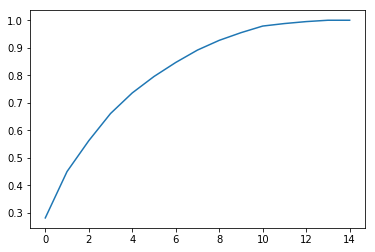

In [92]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
pca = PCA()
pca.fit(grouped_copy[columns_to_use])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [94]:
pca = PCA(n_components=8)
pca_8 = pca.fit_transform(grouped_copy[columns_to_use])

from sklearn.cluster import KMeans

n_clust = KMeans(n_clusters=5, random_state = 0)
n_clust.fit(grouped_copy[columns_to_use])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300, \
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto', \
       random_state=0, tol=0.0001, verbose=0)

# our predicted clusters
cluster_result = n_clust.labels_

In [95]:
# get dictribution of predicted clusters
pd.DataFrame(cluster_result).iloc[:,0].value_counts()

0    488
2    370
1    237
3     53
4      5
Name: 0, dtype: int64

In [96]:
# get dictribution of original clusters
grouped_copy['label_us'] = n_clust.labels_ # add to data frame
orignal_label_count = df_copy.groupby(['author','account_category'],as_index=False).count()
orignal_label_count.account_category.value_counts()

RightTroll      630
LeftTroll       233
Fearmonger      124
HashtagGamer    112
NewsFeed         54
Name: account_category, dtype: int64

In [101]:
grouped_copy[grouped_copy['label_us'] == 0].cls.value_counts()
# RightTroll 0.3904761904761905
# LeftTroll 0.6566523605150214 ! # Therefore, assign 0 to LeftTroll
# HashtagGamer 0.5714285714285714
# Fearmonger 0.18548387096774194
# NewsFeed 0.037037037037037035

RightTroll      246
LeftTroll       153
HashtagGamer     64
Fearmonger       23
NewsFeed          2
Name: cls, dtype: int64

```python
# Method:
print('RightTroll', 246/630)
print('LeftTroll', 153/233)
print('HashtagGamer', 64/112)
print('Fearmonger', 23/124)
print('NewsFeed', 2/54)
# Therefore, assign 0 to LeftTroll
```

In [97]:
grouped_copy[grouped_copy['label_us'] == 2].cls.value_counts()
# RightTroll 0.2920634920634921
# LeftTroll 0.2446351931330472
# HashtagGamer 0.36607142857142855 
# Fearmonger 0.6854838709677419 ! Therefore, assign 2 to Fearmonger
# NewsFeed 0.05555555555555555

RightTroll      184
Fearmonger       85
LeftTroll        57
HashtagGamer     41
NewsFeed          3
Name: cls, dtype: int64

In [99]:
grouped_copy[grouped_copy['label_us'] == 3].cls.value_counts()
# LeftTroll 0.02145922746781116
# HashtagGamer 0.03571428571428571
# Fearmonger 0.12903225806451613
# NewsFeed 0.5925925925925926 ! Therefore, assign 3 to Newsfeed

NewsFeed        32
RightTroll      12
LeftTroll        5
HashtagGamer     4
Name: cls, dtype: int64

In [98]:
grouped_copy[grouped_copy['label_us'] == 1].cls.value_counts()
# RightTroll 0.2904761904761905
# LeftTroll 0.07725321888412018
# HashtagGamer 0.16071428571428573
# Fearmonger 0.12903225806451613
# NewsFeed 0.3148148148148148 ! Newsfeed already assigned, Therefore, assign 1 to RightTroll

RightTroll      183
LeftTroll        18
NewsFeed         17
Fearmonger       16
HashtagGamer      3
Name: cls, dtype: int64

In [102]:
grouped_copy[grouped_copy['label_us'] == 4].cls.value_counts()
# only one left ! Therefore, assign 4 to HashtagGamer

RightTroll    5
Name: cls, dtype: int64

Our model can not really differientiate right trolls from the other types.

In [103]:
# asign cluster number with name based on distribution
label_dic = {'RightTroll':1,'LeftTroll':0,'Fearmonger':2,'HashtagGamer':4,'NewsFeed':3}
sum(grouped_copy['cls'].map(label_dic) == cluster_result)/len(cluster_result)

0.39288811795316564

In [105]:
grouped_copy.head()
# cls is the original cluster, label_us is our predicted cluster

,author,cls,region_change,max_date,min_date,active_days,following_mean,follower_mean,rt_count,tw_count,...,topic_2,topic_3,topic_4,topic_5,avg_tweet,avg_rt,avg_score,following_ratio,rt_ratio,label_us
0,10_GOP,RightTroll,1,2017-10-15,2017-09-07,-0.821388,-0.086378,1.131117,-0.277666,-0.330274,...,0.396541,0.312774,-0.488042,-0.333348,-0.082727,0.034429,0.577971,0.139832,0.327957,0
1,1D_NICOLE_,Fearmonger,1,2015-11-26,2015-05-25,-0.268524,-0.390802,-0.282926,-0.333093,-0.410358,...,0.229888,-0.015622,-0.561763,-0.429861,-0.253490,-0.130034,0.585448,1.136424,0.045455,0
2,1ERIK_LEE,RightTroll,1,2015-09-23,2015-09-23,-0.964305,-0.331496,-0.278372,-0.333093,-0.420612,...,-1.216654,-1.270725,-2.109908,-1.358383,-0.257742,-0.130590,-0.642252,3.229730,1.000000,2
3,2NDHALFONION,RightTroll,1,2017-01-23,2017-01-23,-0.964305,-0.402795,-0.293134,-0.334017,-0.420368,...,1.814197,-1.270725,-2.109908,-1.358383,-0.257742,-0.130590,1.277170,22.000000,0.000000,0
4,4EVER_SUSAN,RightTroll,1,2016-03-22,2015-12-09,-0.573163,-0.385167,-0.281652,-0.323855,-0.405719,...,-0.495023,0.336338,-0.256347,-0.061400,-0.246912,-0.119717,-1.014953,1.309341,0.349206,2
